In [2]:
# import modules
import uproot, sys, time, random, argparse, copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from collections import Counter
from scipy.stats import norm
from math import *

# import trackingError function
from trackingerror import Detector, inputfromfile

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 14.0,10.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 13,
    "title": 13,
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})

#	Width	Resolutionxy	Resolutionz	position
1  	0.00227	9999		9999		0.024
2  	0.01225	1.5e-05		1.5e-05		0.032
3  	0.01225	1.5e-05		1.5e-05		0.068
4  	0.01225	1.5e-05		1.5e-05		0.113
5  	0.01225	1.5e-05		1.5e-05		0.17
6  	0.01475	4.3e-05		0.0012		0.26
7  	0.01475	4.3e-05		0.0012		0.36
8  	0.01475	4.3e-05		0.0012		0.5
9  	0.01475	4.3e-05		0.0012		0.6
10 	0.225	0.072		9999		0.84
11 	0.225	0.072		9999		1.02
Successfully read 11 layers


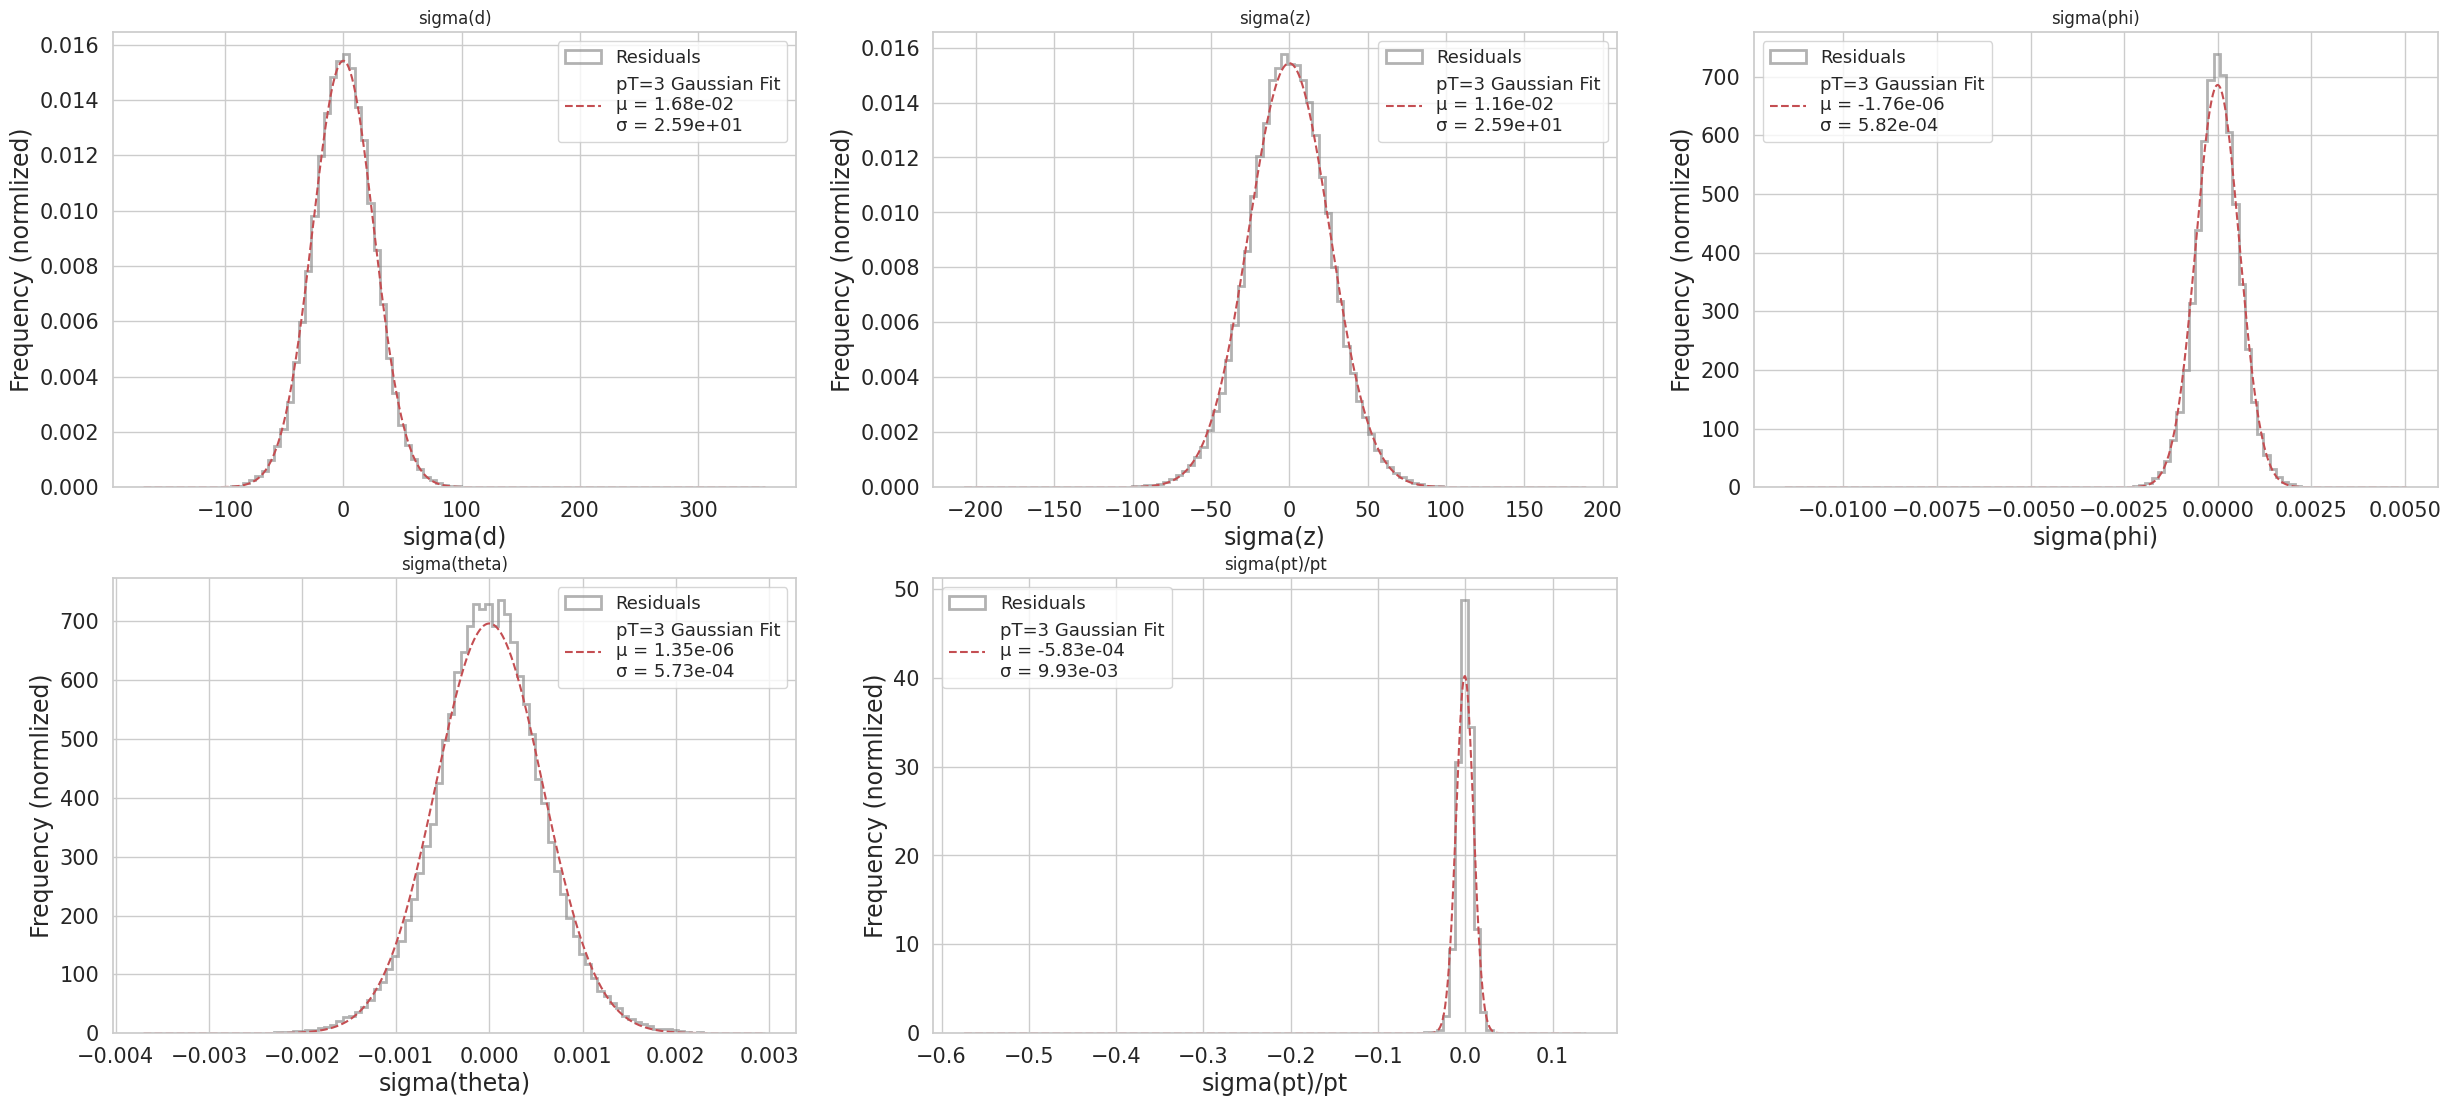

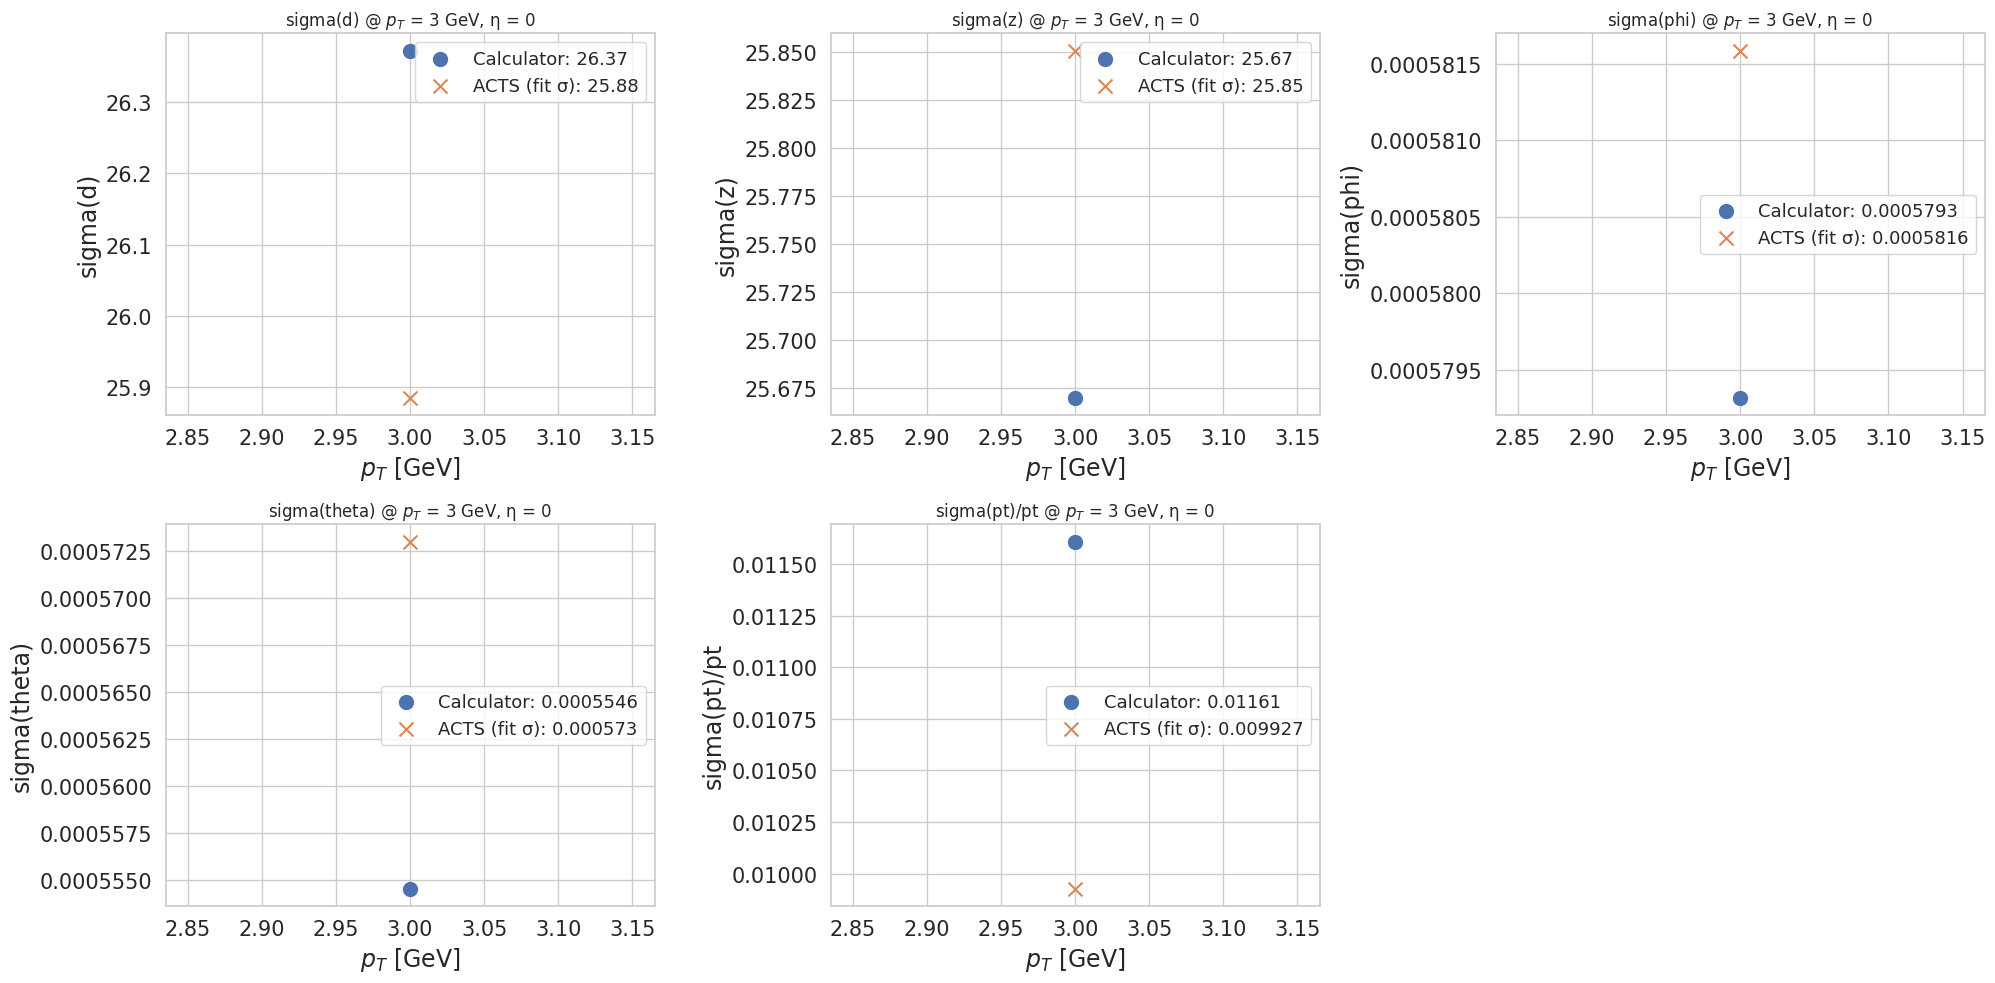

In [13]:
path = '/data/jlai/iris-hep/OutputPT/'
pT_values = [1, 3, 5, 10]
i = 1
file = uproot.open(path + f'output_pt_{pT_values[i]}' + '/tracksummary_ckf.root')
# file = uproot.open("/data/jlai/iris-hep/output_100000/tracksummary_ckf.root")

tree = file['tracksummary']

# < -- Fitting with no plot -- >
arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                      "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                      "t_phi", "ePHI_fit", "res_ePHI_fit",
                      "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                      "t_p", "eQOP_fit", "res_eQOP_fit",
                      "t_charge"], library='ak')

pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['eTHETA_fit'])

labels = {
    'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
    'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
    'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
    'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
    'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth) / pT_truth)
}

fit_results = {}
plt.figure(figsize=(30, 13))
for key, data in labels.items():
    data = ak.to_numpy(data)
    data = data[~np.isnan(data)]

    mu, sigma = norm.fit(data)
    fit_results[key] = sigma
    
    plt.subplot(231 + list(fit_results.keys()).index(key))
    counts, bins, _ = plt.hist(data, bins=100, histtype='step', linewidth=2, density=True, alpha=0.6, color='gray', label='Residuals')

    x = np.linspace(bins[0], bins[-1], 1000)
    plt.plot(x, norm.pdf(x, mu, sigma), 'r--', label=f'pT={pT_values[i]} Gaussian Fit\nμ = {mu:.2e}\nσ = {sigma:.2e}')

    plt.title(key)
    plt.xlabel(key)
    plt.ylabel("Frequency (normlized)")
    plt.legend()
    plt.grid(True)
plt.savefig(f'/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/plots/fitted_gaussian_pT{pT_values[i]}.png')

# < -- Tracking Error Calculator -- >
p, eta = pT_values[i], 0
B, m = 2, 0.106
mydetector = inputfromfile('ODD.txt', 1)
calc_result = mydetector.errorcalculation(p, B, eta, m)

# < -- plot comparsion -- >
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    key = var_label
    y_calc = calc_result[var_label]
    y_acts = fit_results[key]

    plt.scatter(p, y_calc, marker='o', s=100, label=f"Calculator: {y_calc:.4g}")
    plt.scatter(p, y_acts, marker='x', s=100, label=f"ACTS (fit σ): {y_acts:.4g}")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [3]:
path = '/data/jlai/iris-hep/OutputPT/'
var_labels = ['sigma(d)', 'sigma(z)', 'sigma(phi)', 'sigma(theta)', 'sigma(pt)/pt']

y_acts = {label: [] for label in var_labels}
y_acts_err = {label: [] for label in var_labels}

pT_values = np.linspace(1, 10, 10)
for pT_value in pT_values:
    pT_value = int(pT_value)
    print(f'Saving ACTS track resol with pT = {pT_value} GeV')
    file = uproot.open(path + f'output_pt_{pT_value}' + '/tracksummary_ckf.root')
    tree = file['tracksummary']

    # < -- Fitting with no plot -- >
    arrays = tree.arrays(["t_d0", "eLOC0_fit", "res_eLOC0_fit",
                        "t_z0", "eLOC1_fit", "res_eLOC1_fit",
                        "t_phi", "ePHI_fit", "res_ePHI_fit",
                        "t_theta", "eTHETA_fit", "res_eTHETA_fit",
                        "t_p", "t_pT", "eQOP_fit", "res_eQOP_fit",
                        "t_charge"], library='ak')

    pT_truth = arrays['t_p'] * np.sin(arrays['t_theta'])
    pT_reco = np.abs( 1 / arrays['eQOP_fit'] ) * np.sin(arrays['t_theta'])

    labels = {
        'sigma(d)': ak.flatten(arrays['res_eLOC0_fit']) * 1e3, # converting from unit mm to unit um
        'sigma(z)': ak.flatten(arrays['res_eLOC1_fit']) * 1e3, # converting to unit um
        'sigma(phi)': ak.flatten(arrays['res_ePHI_fit']),
        'sigma(theta)': ak.flatten(arrays['res_eTHETA_fit']),
        'sigma(pt)/pt': ak.flatten((pT_reco - pT_truth) / pT_truth)
    }

    plt.figure(figsize=(30, 13))
    for key, data in labels.items():
        data = ak.to_numpy(data)
        data = data[~np.isnan(data)]

        mu, sigma = norm.fit(data)

        N = len(data)
        mu, sigma = norm.fit(data)
        y_acts[key].append(sigma)
        y_acts_err[key].append(sigma / np.sqrt(2 * N) if N > 0 else 0)

Saving ACTS track resol with pT = 1 GeV
Saving ACTS track resol with pT = 2 GeV
Saving ACTS track resol with pT = 3 GeV
Saving ACTS track resol with pT = 4 GeV
Saving ACTS track resol with pT = 5 GeV
Saving ACTS track resol with pT = 6 GeV
Saving ACTS track resol with pT = 7 GeV
Saving ACTS track resol with pT = 8 GeV
Saving ACTS track resol with pT = 9 GeV
Saving ACTS track resol with pT = 10 GeV


<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

<Figure size 3000x1300 with 0 Axes>

Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers
Successfully read 11 layers


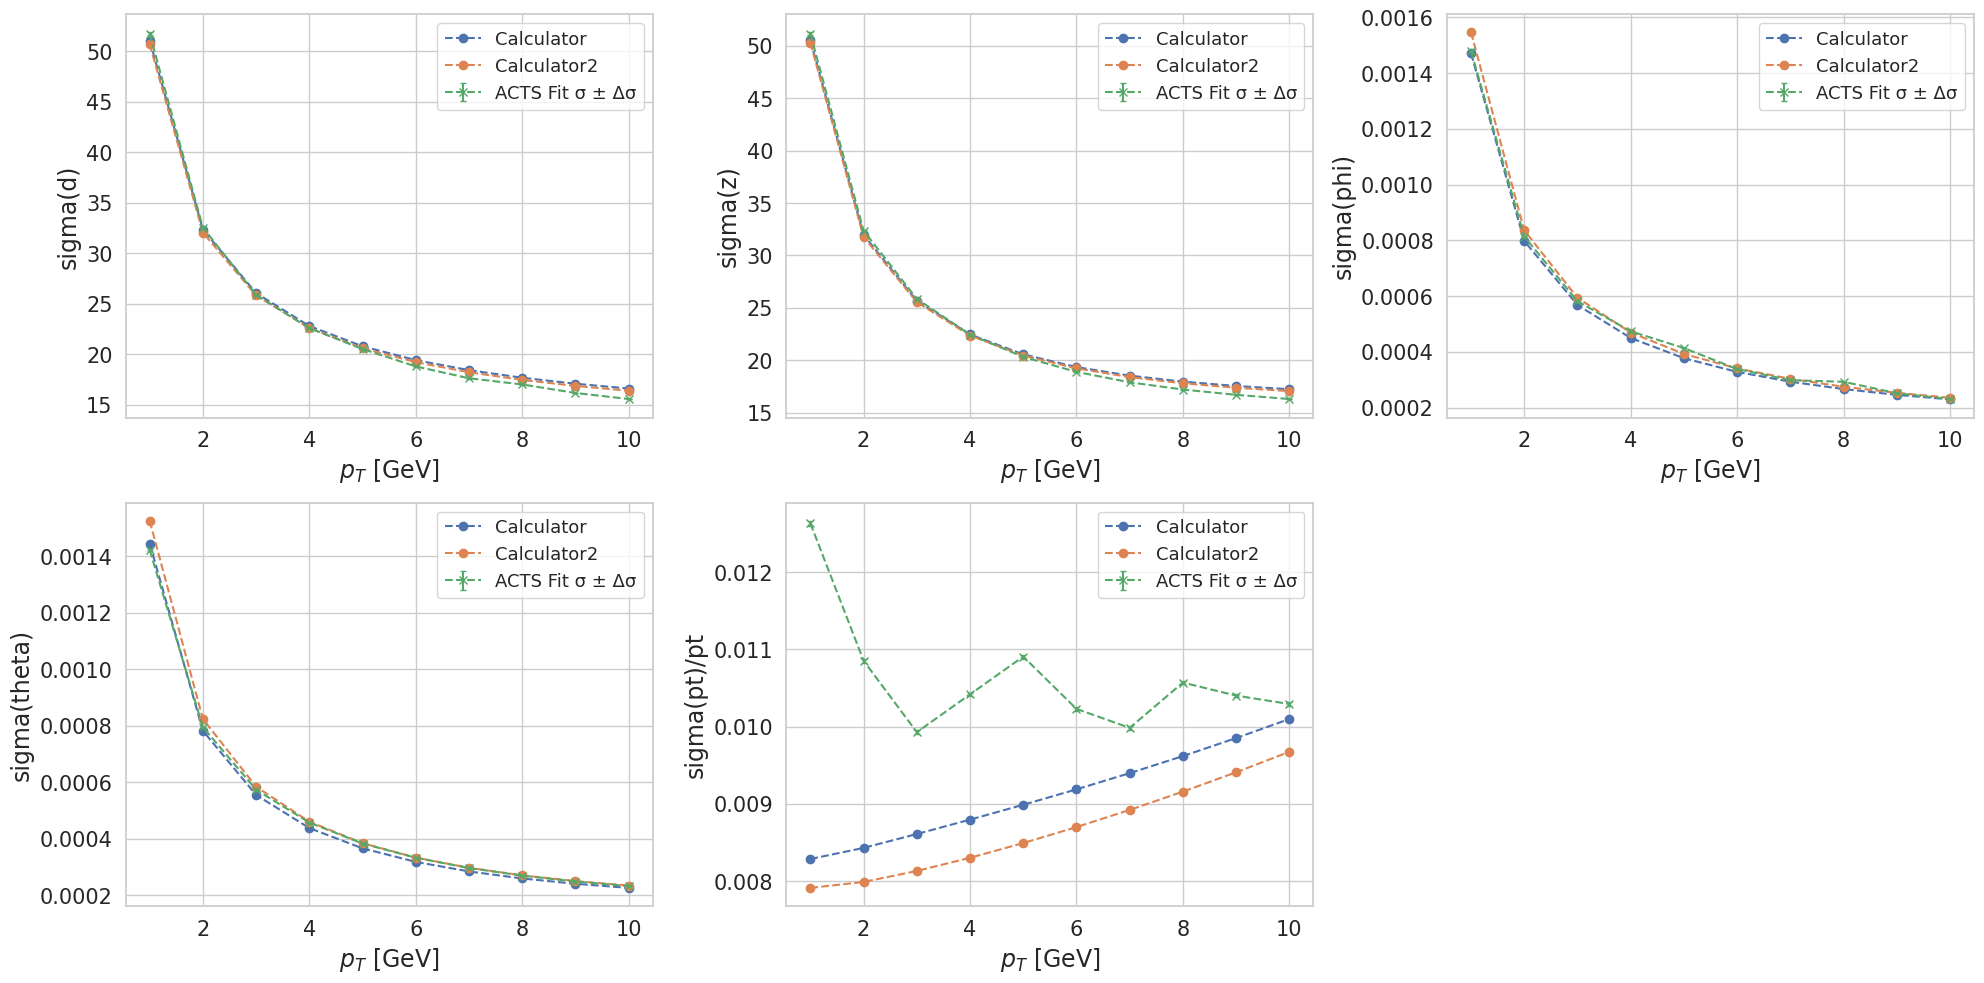

In [20]:
# < -- Tracking Error Calculator -- >
def cal(inputfile='ODD.txt'):
    y_calc = {label: [] for label in var_labels}

    for pT_value in pT_values:
        pT_value = int(pT_value)
        p, eta = pT_value, 0
        B, m = 2, 0.106
        mydetector = inputfromfile(inputfile, 0)
        calc_result = mydetector.errorcalculation(p, B, eta, m)

        for var_label in var_labels:
            y_calc[var_label].append(calc_result[var_label])
    return y_calc

path = '/data/jlai/iris-hep-log/TrackingResolution-3.0/TrackingResolution-3.0/'
y_calc = cal(path+'ODD.txt')
y_calc2 = cal(path+'myODD3.txt')

# < -- plot the var vs. pT -- >
plt.figure(figsize=(20, 10))
for var_label in var_labels:
    idx = var_labels.index(var_label)
    plt.subplot(231 + idx)

    plt.plot(pT_values, y_calc[var_label], 'o--', label=f"Calculator")
    plt.plot(pT_values, y_calc2[var_label], 'o--', label=f"Calculator2")
    # plt.plot(pT_values, y_acts[var_label], 'x--', label=f"ACTS (fit σ)")
    plt.errorbar(pT_values, y_acts[var_label], yerr=y_acts_err[var_label], fmt='x--', capsize=2, label="ACTS Fit σ ± Δσ")
    plt.xlabel(r"$p_T$ [GeV]")
    plt.ylabel(var_label)
    # plt.title(f"{var_label} @ $p_T$ = {p} GeV, η = {eta}")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
